In [1]:
# conda install keras-tuner
import keras_tuner as kt
import pandas as pd
import numpy as np
import keras
from datetime import datetime
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras import losses
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
# import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.callbacks import *


2022-12-02 14:29:07.644331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Bitcoin

In [3]:
regs = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
for i in range(len(btc['Date'])):
    btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')

btc = btc.set_index("Date")

/tmp/ipykernel_247881/2421463472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')


In [4]:
btcData = btc[regs.columns]

In [5]:
btcData['returns'] = btcData['priceUSD'].pct_change()

/tmp/ipykernel_247881/751970969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change()


In [6]:
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [7]:
Data 

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.055500e+01,8.384389e+08,1.757449e+17,0.000,0.000,401834.0000,...,0.0,0,2.612000e+03,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,1.621380e+02,1.641620e+02,100.00,1.737230e+02,2.248600e+01,8.819952e+08,1.944789e+17,0.000,0.000,481473.0000,...,0.0,0,4.047000e+03,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,1.584060e+02,1.641620e+02,100.00,1.735570e+02,2.441400e+01,9.280542e+08,2.153212e+17,0.000,0.000,431831.0000,...,0.0,0,2.341000e+03,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475
2010-07-21,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.630400e+01,9.761949e+08,2.382391e+17,0.000,0.000,460783.0000,...,0.0,0,2.122000e+03,25.638,0.092,67.334,0.284,78.431,0.541,-0.020434
2010-07-22,1.580420e+02,1.641620e+02,100.00,1.700790e+02,2.819400e+01,1.019474e+09,2.598318e+17,0.000,0.000,334641.0000,...,0.0,0,2.570000e+03,25.604,0.078,66.526,0.275,78.166,0.537,-0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.384949e+13,4.612156e+19,5.317997e+38,165.380,0.818,0.0577,...,18820.0,28544682257,6.114577e+09,15.236,-0.080,40.118,-0.042,45.140,0.001,0.008075
2022-11-25,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.394503e+13,4.542600e+19,5.158804e+38,214.464,0.812,0.0541,...,18759.0,28076113671,7.224812e+09,15.231,-0.075,39.880,-0.043,45.047,0.001,-0.006565
2022-11-26,1.882952e+11,1.148115e+11,99.86,8.598887e+12,3.404058e+13,4.624135e+19,5.345655e+38,255.004,0.809,0.0571,...,18701.0,27566714445,4.898449e+09,15.233,-0.070,40.069,-0.043,45.106,0.001,0.004001


In [8]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然

In [9]:
X.head(3)

,difficulty14mom,difficulty30mom,difficulty3rsi,difficulty90mom,difficulty90sma,hashrate90std,hashrate90var,median_transaction_fee90rocUSD,median_transaction_feeUSD,mining_profitability,...,price90wmaUSD,sentinusd90emaUSD,sentinusdUSD,top100cap,top100cap14trx,top100cap30rsi,top100cap30trx,top100cap90rsi,top100cap90trx,returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,162.138,164.162,100.0,173.723,20.555,838438881.0,1.757449e+17,0.0,0.0,401834.0,...,0.0,0,2612.0,25.782,0.139,71.191,0.308,79.756,0.550,0.466667
2010-07-19,162.138,164.162,100.0,173.723,22.486,881995244.0,1.944789e+17,0.0,0.0,481473.0,...,0.0,0,4047.0,25.685,0.123,68.863,0.300,78.999,0.547,0.183196
2010-07-20,158.406,164.162,100.0,173.557,24.414,928054231.0,2.153212e+17,0.0,0.0,431831.0,...,0.0,0,2341.0,25.602,0.107,66.923,0.292,78.355,0.544,-0.088475


In [10]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [11]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [12]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
# define neural network model
shape=X.shape[1]
def build_model(hp, initializer='normal', activation='relu', NUM_FEATURES=shape):
    # create model
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model = Sequential()
    model.add(Dense(hp_units1, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(hp_units2, activation=activation))
    model.add(Dense(hp_units3, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    directory='btc_tune',
    project_name='ANN_TUNE'
)

tuner.search(X_train, Y_train, epochs=5000, validation_data=(X_val, Y_val))

Trial 9 Complete [01h 12m 32s]
val_mae: 904.3529052734375

Best val_mae So Far: 904.3529052734375
Total elapsed time: 03h 08m 45s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
416               |256               |units1
288               |416               |units2
288               |32                |units3

Learning rate:  0.001
Epoch 1/5000
46/46 [==============================] - 1s 17ms/step - loss: 4473.8027 - mae: 4474.4946 - val_loss: 17747.3750 - val_mae: 17748.0703
Epoch 2/5000
46/46 [==============================] - 1s 13ms/step - loss: 2416.6565 - mae: 2417.3486 - val_loss: 4177.9028 - val_mae: 4178.5967
Epoch 3/5000
46/46 [==============================] - 1s 17ms/step - loss: 1008.1214 - mae: 1008.8141 - val_loss: 3154.6248 - val_mae: 3155.3174
Epoch 4/5000
46/46 [==============================] - 0s 9ms/step - loss: 786.7394 - mae: 787.4313 - val_loss: 2907.4182 - val_mae: 2908.1116
Epoch 5/5000
46/46 [==============================] 

In [ ]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
regressor = build_model(best_hp)
# Fit with the entire dataset.
X_all = np.concatenate((X_train, X_val))
Y_all = np.concatenate((Y_train, Y_val))


In [ ]:
# best hyperparameters
best_hp

val_loss is the value of cost function for your cross-validation data and loss is the value of cost function for your training data.

stop training when val_loss is not increasing

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=1000,verbose=1, mode='auto')

In [ ]:
regressor.fit(x=X_all, y=Y_all, epochs=5000, use_multiprocessing=True, callbacks=[earlyStopping])

/tmp/ipykernel_26820/1361768653.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor=KerasRegressor(build_fn=sequential_model,epochs=5000,verbose=1, use_multiprocessing=True)


In [ ]:

y_pred=regressor.predict(X_test)

In [ ]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

1461/1461 [==============================] - 0s 127us/step


0.9966428561796283

In [ ]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:0.3289147112445364


In [ ]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [ ]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.9181680230673898


In [ ]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:8630.756097837935
rmse:11084.832551513839
mape:24.996031025506138


-----------------------------

In [ ]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

546/546 [==============================] - 0s 83us/step


,y_test,y_pred
Date,,
2021-06-01,33731.0,34394.320312
2021-06-02,33285.0,34062.855469
2021-06-03,34298.0,33482.195312
2021-06-04,35271.0,34105.074219
2021-06-05,34100.0,33992.710938
...,...,...
2022-11-24,NaN,24159.792969
2022-11-25,NaN,23844.636719
2022-11-26,NaN,23678.773438


In [ ]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [ ]:
pre_df

,y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,34394.320312,NaN
2021-06-02,33285.0,34062.855469,-0.009637
2021-06-03,34298.0,33482.195312,-0.017047
2021-06-04,35271.0,34105.074219,0.018603
2021-06-05,34100.0,33992.710938,-0.003295
...,...,...,...
2022-11-24,NaN,24159.792969,-0.012123
2022-11-25,NaN,23844.636719,-0.013045
2022-11-26,NaN,23678.773438,-0.006956


<AxesSubplot:>

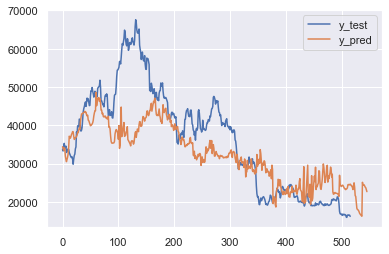

In [ ]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [ ]:
pre_df.to_csv("../result/ANN/btc_NN.csv")

In [3]:
!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'